## Data Preprocessing

To make the images in the same dimension\
Use patchify....\
Tile 1: 797 x 644 --> 768 x 512 --> 6\
Tile 2: 509 x 544 --> 512 x 256 --> 2\
Tile 3: 682 x 658 --> 512 x 512  --> 4\
Tile 4: 1099 x 846 --> 1024 x 768 --> 12\
Tile 5: 1126 x 1058 --> 1024 x 1024 --> 16\
Tile 6: 859 x 838 --> 768 x 768 --> 9\
Tile 7: 1817 x 2061 --> 1792 x 2048 --> 56\
Tile 8: 2149 x 1479 --> 1280 x 2048 --> 40\
Total 9 images in each folder * (145 patches) = 1305\
Total 1305 patches of size 256x256

In [28]:
import os
import cv2
import random
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [3]:
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [4]:
from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [5]:
scaler = MinMaxScaler()

root_directory = 'satellite-images/'

patch_size = 256

In [19]:
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        images = os.listdir(path)
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):
                image = cv2.imread(path+"/"+image_name, 1)
                SIZE_X = (image.shape[1]//patch_size)*patch_size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                image = np.array(image)

                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):

                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)
            

Now patchifying image: satellite-images/Tile 8/images/image_part_004.jpg
Now patchifying image: satellite-images/Tile 8/images/image_part_005.jpg
Now patchifying image: satellite-images/Tile 8/images/image_part_007.jpg
Now patchifying image: satellite-images/Tile 8/images/image_part_006.jpg
Now patchifying image: satellite-images/Tile 8/images/image_part_002.jpg
Now patchifying image: satellite-images/Tile 8/images/image_part_003.jpg
Now patchifying image: satellite-images/Tile 8/images/image_part_001.jpg
Now patchifying image: satellite-images/Tile 8/images/image_part_008.jpg
Now patchifying image: satellite-images/Tile 8/images/image_part_009.jpg
Now patchifying image: satellite-images/Tile 1/images/image_part_004.jpg
Now patchifying image: satellite-images/Tile 1/images/image_part_005.jpg
Now patchifying image: satellite-images/Tile 1/images/image_part_007.jpg
Now patchifying image: satellite-images/Tile 1/images/image_part_006.jpg
Now patchifying image: satellite-images/Tile 1/imag

In [20]:
print(image_dataset)

[array([[[0.35950413, 0.45338983, 0.41048035],
        [0.40495868, 0.5       , 0.45851528],
        [0.31818182, 0.41101695, 0.37117904],
        ...,
        [0.57438017, 0.5720339 , 0.56768559],
        [0.68181818, 0.68644068, 0.68558952],
        [0.54958678, 0.54237288, 0.54585153]],

       [[0.38016529, 0.47457627, 0.43231441],
        [0.42561983, 0.52118644, 0.48034934],
        [0.3677686 , 0.46186441, 0.42358079],
        ...,
        [0.59917355, 0.59745763, 0.59388646],
        [0.59090909, 0.58898305, 0.58515284],
        [0.53719008, 0.52966102, 0.53275109]],

       [[0.3677686 , 0.46186441, 0.41921397],
        [0.41322314, 0.50847458, 0.46724891],
        [0.40082645, 0.49576271, 0.45851528],
        ...,
        [0.7107438 , 0.69915254, 0.70742358],
        [0.59917355, 0.58474576, 0.58951965],
        [0.57024793, 0.55084746, 0.56768559]],

       ...,

       [[0.27272727, 0.36440678, 0.35371179],
        [0.24793388, 0.33898305, 0.32751092],
        [0.25206612, 

In [21]:
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':
        masks = os.listdir(path)
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):
               
                mask = cv2.imread(path+"/"+mask_name, 1)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size 
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size 
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        single_patch_mask = single_patch_mask[0]
                        mask_dataset.append(single_patch_mask) 

Now patchifying mask: satellite-images/Tile 8/masks/image_part_004.png
Now patchifying mask: satellite-images/Tile 8/masks/image_part_005.png
Now patchifying mask: satellite-images/Tile 8/masks/image_part_007.png
Now patchifying mask: satellite-images/Tile 8/masks/image_part_006.png
Now patchifying mask: satellite-images/Tile 8/masks/image_part_002.png
Now patchifying mask: satellite-images/Tile 8/masks/image_part_003.png
Now patchifying mask: satellite-images/Tile 8/masks/image_part_001.png
Now patchifying mask: satellite-images/Tile 8/masks/image_part_008.png
Now patchifying mask: satellite-images/Tile 8/masks/image_part_009.png
Now patchifying mask: satellite-images/Tile 1/masks/image_part_004.png
Now patchifying mask: satellite-images/Tile 1/masks/image_part_005.png
Now patchifying mask: satellite-images/Tile 1/masks/image_part_007.png
Now patchifying mask: satellite-images/Tile 1/masks/image_part_006.png
Now patchifying mask: satellite-images/Tile 1/masks/image_part_002.png
Now pa

In [27]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
print("Image dataset shape: {}".format(image_dataset.shape))
print("Mask dataset shape: {}".format(mask_dataset.shape))

Image dataset shape: (1305, 256, 256, 3)
Mask dataset shape: (1305, 256, 256, 3)


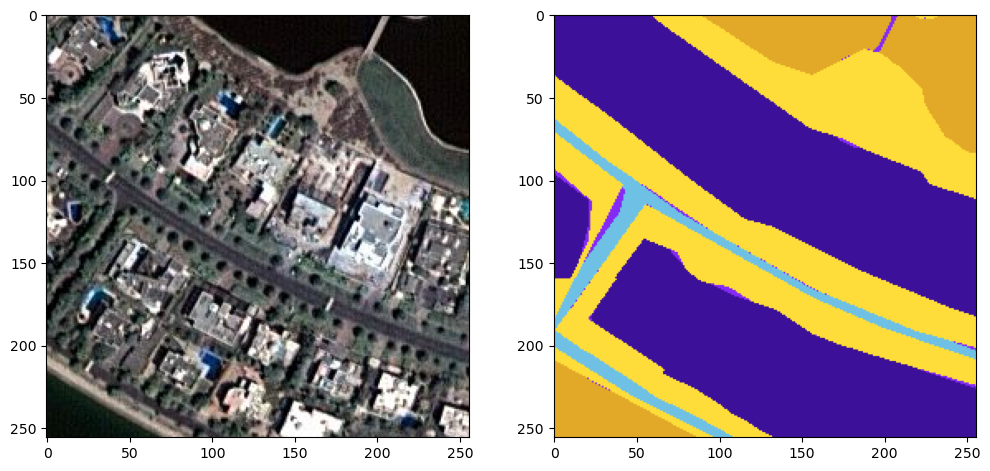

In [40]:
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()